In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from collections import Counter, defaultdict
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

In [2]:
snippet_pos = pickle.load(open('snippet_pos.p', 'rb'))
questions = pickle.load(open('questions.p', 'rb'))

In [3]:
full_feature_samples, semi_feature_samples, bin_feature_samples, acconly_baseline_samples, allpost_baseline_samples, random_samples = pickle.load(open('samples.added_feat.p', 'rb'))
folds = [1, 2, 3, 4, 5]
full_feature_samples = [x for x in full_feature_samples if x['fold_id'] in folds]
semi_feature_samples = [x for x in semi_feature_samples if x['fold_id'] in folds]
bin_feature_samples = [x for x in bin_feature_samples if x['fold_id'] in folds]

In [4]:
print 'acconly: %d examples' % len(acconly_baseline_samples)
print 'all: %d examples' % len(allpost_baseline_samples)

acconly: 55 examples
all: 674 examples


In [5]:
def create_points_count(samples, do_print=False, is_random=False):
    xaxis = [0]
    yaxis = [0]
#     if fold_id != 'all':
#         samples = [x for x in samples if x['fold_id'] == fold_id]
    for sample in samples:
#         if is_random:
#             pid, intent, code, is_annotated = sample
#         else:
#             _, pid, intent, code, x, is_annotated = sample
        xaxis.append(xaxis[-1] + 1)
        yaxis.append(yaxis[-1] + int(sample['example']['label']))
        if do_print:
            print 'post_id:'
            print pid
            print 'intent:'
            print intent
            print 'code:'
            print code
            print 'features:'
            print x
            print 'confidence:'
            print _[1]
            print '----------------------------\n\n\n'
    return xaxis, yaxis

In [6]:
def create_points_precrec(samples, do_print=False, is_random=False):
    xaxis = [0]
    yaxis = [1]
    correct = 0
    total_selected = 0
    
#     if fold_id != 'all':
#         samples = [x for x in samples if x['fold_id'] == fold_id]
    
    for sample in samples:
        is_annotated = sample['example']['label']
        total_selected += 1
        correct += int(is_annotated)
        
        recall = correct / float(total_annotated)
        precision = correct / float(total_selected)
        
        xaxis.append(recall)
        yaxis.append(precision)
        
        if recall >= 1.:
            break
        
        if do_print:
            print 'post_id:'
            print pid
            print 'intent:'
            print intent
            print 'code:'
            print code
            print 'features:'
            print x
            print 'confidence:'
            print _[1]
            print '----------------------------\n\n\n'
    return xaxis, yaxis

In [7]:
# create_points = create_points_count
create_points = create_points_precrec
total_annotated = sum(map(lambda x: x['example']['label'], full_feature_samples))
print total_annotated

473


In [8]:
full_feature_x, full_feature_y = create_points(full_feature_samples)

In [9]:
semi_feature_x, semi_feature_y = create_points(semi_feature_samples)

In [10]:
bin_feature_x, bin_feature_y = create_points(bin_feature_samples)

In [11]:
random_x, random_y = create_points(random_samples, is_random=True)

In [12]:
baseline_x, baseline_y = create_points(acconly_baseline_samples, is_random=True)

In [13]:
# baseline_mined = [len(baseline_samples)]
# baseline_pos = [sum(1 for pid, intent, code, is_annotated in baseline_samples if is_annotated)]
baseline_wins = sum([1 for e in acconly_baseline_samples if e['example']['label']])
print baseline_wins

13


In [14]:
def get_y_true_and_predictor_scores(samples, is_random=False, is_baseline=False):
    y_true = np.array(map(lambda x: 1 if x['example']['label'] else 0, samples))
    if is_random:
        predictor_scores = np.array(range(len(samples))[::-1], dtype='float32')
    elif is_baseline:
        predictor_scores = np.ones(len(samples))
    else:
        predictor_scores = np.array(map(lambda x: x['probability'], full_feature_samples))
    
    return y_true, predictor_scores

[0.23636363636363636] [0.23738872403560832]


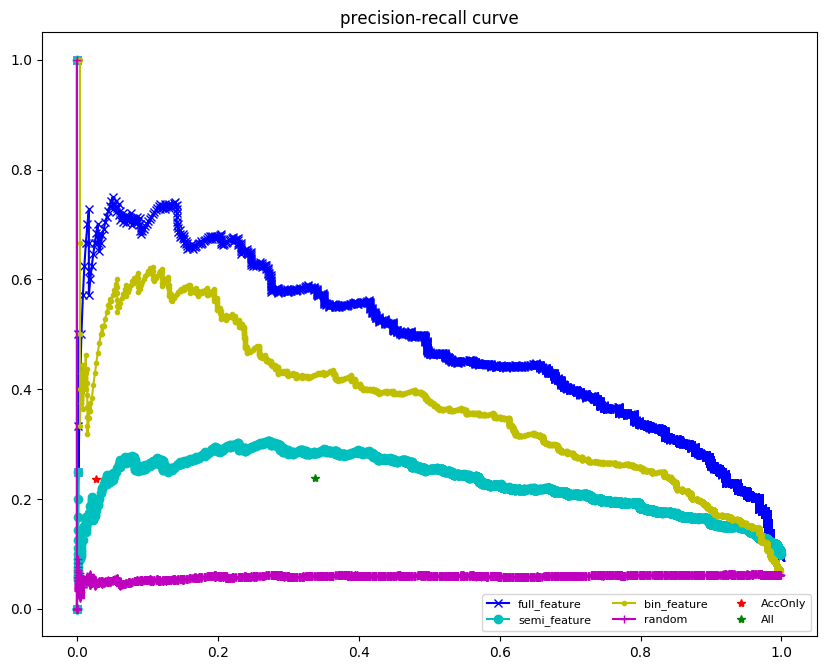

In [15]:
plt.figure(figsize=(10, 8))
ax = plt.subplot()
colors = ['b', 'c', 'y', 'm', 'r', 'g']

full_feature, = plt.plot(full_feature_x, full_feature_y, 'x-', color=colors[0])
semi_feature, = plt.plot(semi_feature_x, semi_feature_y, 'o-', color=colors[1])
bin_feature,  = plt.plot(bin_feature_x, bin_feature_y, '.-', color=colors[2])
random_selection,  = plt.plot(random_x, random_y, '+-', color=colors[3])
# baseline_model,  = plt.plot(baseline_x, baseline_y, '*-', color=colors[4])

y_true_acconly_baseline, scores_acconly_baseline = get_y_true_and_predictor_scores(acconly_baseline_samples, is_baseline=True)
y_true_allpost_baseline, scores_allpost_baseline = get_y_true_and_predictor_scores(allpost_baseline_samples, is_baseline=True)
y_true_full_feat, scores_full_feat = get_y_true_and_predictor_scores(full_feature_samples)

precision_acconly_baseline = [sum(y_true_acconly_baseline) / float(len(y_true_acconly_baseline))]
recall_acconly_baseline = [sum(y_true_acconly_baseline) / float(sum(y_true_full_feat))]

precision_allpost_baseline = [sum(y_true_allpost_baseline) / float(len(y_true_allpost_baseline))]
recall_allpost_baseline = [sum(y_true_allpost_baseline) / float(sum(y_true_full_feat))]

print precision_acconly_baseline, precision_allpost_baseline

acconly_baseline_model,  = plt.plot(recall_acconly_baseline, precision_acconly_baseline, '*', color=colors[4])
allpost_baseline_model,  = plt.plot(recall_allpost_baseline, precision_allpost_baseline, '*', color=colors[5])

plt.legend((full_feature, semi_feature, bin_feature, random_selection, acconly_baseline_model, allpost_baseline_model),
          ('full_feature', 'semi_feature', 'bin_feature', 'random', 'AccOnly', 'All'),
          scatterpoints=1,
          loc='lower right',
          ncol=3,
          fontsize=8)
#ax.set_xlim([0, 100])
#ax.set_ylim([0, 100])
plt.title('precision-recall curve')
plt.show()

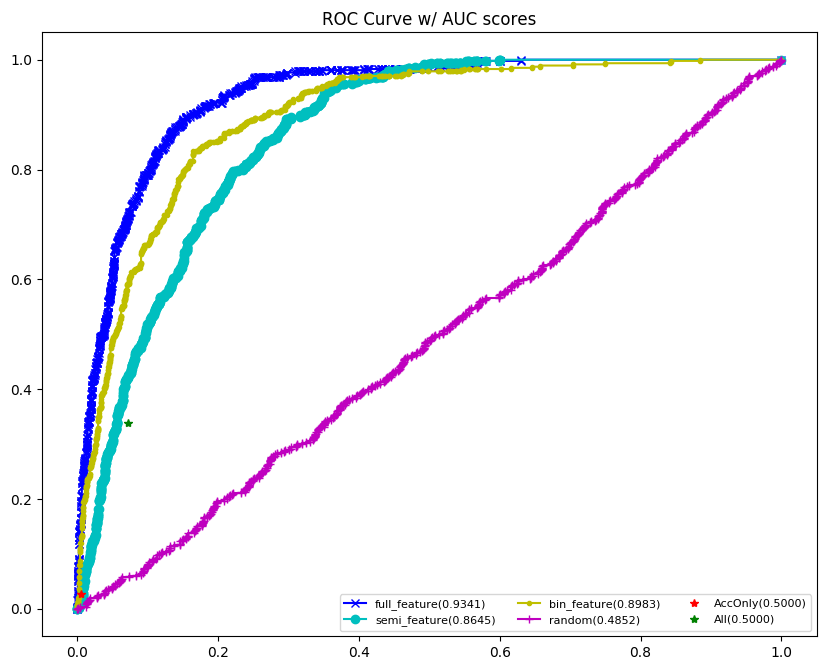

In [16]:
# precision, recall, thresholds = precision_recall_curve(y_true, probas_pred, pos_label=1)
# print precision[::-1][:10], full_feature_y[:10]
# print recall[::-1][:10], full_feature_x[:10]

# plt.figure(figsize=(10, 10))
# plt.plot(recall, precision, 'x-',)
# plt.show()

y_true_full_feat, scores_full_feat = get_y_true_and_predictor_scores(full_feature_samples)
fpr_full_feat, tpr_full_feat, thresholds_full_feat = roc_curve(y_true_full_feat, scores_full_feat, pos_label=1)
roc_auc_full_feat = roc_auc_score(y_true_full_feat, scores_full_feat)

y_true_semi_feat, scores_semi_feat = get_y_true_and_predictor_scores(semi_feature_samples)
fpr_semi_feat, tpr_semi_feat, thresholds_semi_feat = roc_curve(y_true_semi_feat, scores_semi_feat, pos_label=1)
roc_auc_semi_feat = roc_auc_score(y_true_semi_feat, scores_semi_feat)

y_true_bin_feat, scores_bin_feat = get_y_true_and_predictor_scores(bin_feature_samples)
fpr_bin_feat, tpr_bin_feat, thresholds_bin_feat = roc_curve(y_true_bin_feat, scores_bin_feat, pos_label=1)
roc_auc_bin_feat = roc_auc_score(y_true_bin_feat, scores_bin_feat)

y_true_rand, scores_rand = get_y_true_and_predictor_scores(random_samples, is_random=True)
fpr_rand, tpr_rand, thresholds_rand = roc_curve(y_true_rand, scores_rand, pos_label=1)
roc_auc_rand = roc_auc_score(y_true_rand, scores_rand)

y_true_baseline, scores_baseline = get_y_true_and_predictor_scores(acconly_baseline_samples, is_baseline=True)
fpr_baseline, tpr_baseline, thresholds_baseline = roc_curve(y_true_baseline, scores_baseline, pos_label=1)
roc_auc_baseline = roc_auc_score(y_true_baseline, scores_baseline)
tpr_baseline = [sum(y_true_baseline) / float(sum(y_true_full_feat))]
fpr_baseline = [(len(y_true_baseline) - sum(y_true_baseline)) / float(len(y_true_full_feat) - sum(y_true_full_feat))]

y_true_allpost_baseline, scores_allpost_baseline = get_y_true_and_predictor_scores(allpost_baseline_samples, is_baseline=True)
fpr_allpost_baseline, tpr_allpost_baseline, thresholds_allpost_baseline = roc_curve(y_true_baseline, scores_baseline, pos_label=1)
roc_auc_allpost_baseline = roc_auc_score(y_true_allpost_baseline, scores_allpost_baseline)
tpr_allpost_baseline = [sum(y_true_allpost_baseline) / float(sum(y_true_full_feat))]
fpr_allpost_baseline = [(len(y_true_allpost_baseline) - sum(y_true_allpost_baseline)) / float(len(y_true_full_feat) - sum(y_true_full_feat))]

plt.figure(figsize=(10, 8))

full_feature, = plt.plot(fpr_full_feat, tpr_full_feat, 'x-', color=colors[0])
semi_feature, = plt.plot(fpr_semi_feat, tpr_semi_feat, 'o-', color=colors[1])
bin_feature,  = plt.plot(fpr_bin_feat, tpr_bin_feat, '.-', color=colors[2])
random_selection,  = plt.plot(fpr_rand, tpr_rand, '+-', color=colors[3])
baseline_model,  = plt.plot(fpr_baseline, tpr_baseline, '*', color=colors[4])
allpost_baseline_model,  = plt.plot(fpr_allpost_baseline, tpr_allpost_baseline, '*', color=colors[5])

plt.legend((full_feature, semi_feature, bin_feature, random_selection, baseline_model, allpost_baseline_model),
          ('full_feature(%.4f)' % roc_auc_full_feat, 
           'semi_feature(%.4f)' % roc_auc_semi_feat, 
           'bin_feature(%.4f)' % roc_auc_bin_feat,
           'random(%.4f)' % roc_auc_rand,
           'AccOnly(%.4f)' % roc_auc_baseline,
           'All(%.4f)' % roc_auc_allpost_baseline),
          scatterpoints=1,
          loc='lower right',
          ncol=3,
          fontsize=8)

plt.title('ROC Curve w/ AUC scores')

plt.show()

In [17]:
for i, sample in enumerate(full_feature_samples[:100]):
    # if sample['example']['label'] == False:
        print i, questions[sample['example']['question_id']]['title'], sample

0 How can I make a time delay in Python? {'fold_id': 4, 'predict_label': 1, 'example': {'code': 'time.sleep(time.localtime(time.time())[5])', 'features': {'ll_answer_post_zscore_code2nl': 2.31712695902897, 'll_max': -20.642177581787109, 'll_snippet_zscore_nl2code': 0.0, 'll_page_zscore_nl2code': -3.721044236577475, 'll_min': -39.407356262207031, 'post_rank_2': 1, 'll_page_max_zscore': 2.5030226044944701, 'start_of_block': True, 'contains_import': False, 'll_page_zscore_code2nl': 2.5030226044944701, 'single_value': False, 'start_with_assign': False, 'num_lines': 1, 'll_page_min_zscore': -3.721044236577475, 'end_of_line': True, 'll_answer_post_zscore_nl2code': -2.4258825956700898, 'accepted_ans': False, 'accepted_ans && only_snippet': False, 'll_nl2code': -39.40735626220703, 'start_with_assign && num_lines=1': False, 'only_snippet': False, 'whole_block': True, 'num_lines=1': 1, 'end_of_block': True, 'accepted_ans && only_snippet && whole_block': False, 'll_code2nl': -20.64217758178711, '

In [18]:
for i, sample in enumerate(bin_feature_samples[:200]):
    # if sample['example']['label'] == False:
        print i, questions[sample['example']['question_id']]['title'], sample

0 Generate random numbers with a given (numerical) distribution {'fold_id': 2, 'predict_label': 1, 'example': {'code': 'numpy.random.choice(numpy.arange(1, 7), p=[0.1, 0.05, 0.05, 0.2, 0.4, 0.2])', 'features': {'ll_answer_post_zscore_code2nl': 0.0, 'll_max': -42.512901306152344, 'll_snippet_zscore_nl2code': 0.0, 'll_page_zscore_nl2code': 0.33474165503646797, 'll_min': -70.121917724609375, 'post_rank_0': 1, 'll_page_max_zscore': 0.68242887444971101, 'start_of_block': True, 'contains_import': False, 'll_page_zscore_code2nl': 0.68242887444971101, 'single_value': False, 'start_with_assign': False, 'num_lines': 1, 'll_page_min_zscore': 0.33474165503646797, 'end_of_line': True, 'll_answer_post_zscore_nl2code': 0.0, 'accepted_ans': True, 'accepted_ans && only_snippet': True, 'll_nl2code': -70.12191772460938, 'start_with_assign && num_lines=1': False, 'only_snippet': True, 'whole_block': True, 'num_lines=1': 1, 'end_of_block': True, 'accepted_ans && only_snippet && whole_block': True, 'll_code

In [19]:
for i, sample in enumerate(semi_feature_samples[:100]):
    # if sample['example']['label'] == False:
        print i, questions[sample['example']['question_id']]['title'], sample

0 How can I make a time delay in Python? {'fold_id': 4, 'predict_label': 1, 'example': {'code': 'time.sleep(time.localtime(time.time())[5])', 'features': {'ll_answer_post_zscore_code2nl': 2.31712695902897, 'll_max': -20.642177581787109, 'll_snippet_zscore_nl2code': 0.0, 'll_page_zscore_nl2code': -3.721044236577475, 'll_min': -39.407356262207031, 'post_rank_2': 1, 'll_page_max_zscore': 2.5030226044944701, 'start_of_block': True, 'contains_import': False, 'll_page_zscore_code2nl': 2.5030226044944701, 'single_value': False, 'start_with_assign': False, 'num_lines': 1, 'll_page_min_zscore': -3.721044236577475, 'end_of_line': True, 'll_answer_post_zscore_nl2code': -2.4258825956700898, 'accepted_ans': False, 'accepted_ans && only_snippet': False, 'll_nl2code': -39.40735626220703, 'start_with_assign && num_lines=1': False, 'only_snippet': False, 'whole_block': True, 'num_lines=1': 1, 'end_of_block': True, 'accepted_ans && only_snippet && whole_block': False, 'll_code2nl': -20.64217758178711, '